In [2]:
import pandas as pd
import geopandas as gpd

import seaborn as sns
import pylab as plt
import folium
import pysal as ps
from crime_tool import load_datasets

%matplotlib inline

In [3]:
# get cleaned data
df = load_datasets.load_crime_stats(population_group='ages', 
                                    crime_list=['Drug-related crime','Driving under the influence of alcohol or drugs'],
                                   provence='Western Cape')
df.head()

,small_area,precinct,a70_79,a40_49,a30_39,a10_19,a80_plus,a0_9,a60_69,a50_59,a20_29,geometry,Province,Crime,Year,total_crime
0,1600049,vanrhynsdorp,18.0,114.0,72.0,84.0,3.0,120.0,36.0,75.0,135.0,"POLYGON ((18.9239346 -31.56851169, 18.9241632 ...",western cape,Driving under the influence of alcohol or drugs,2005,0.770022
1,1600049,vanrhynsdorp,18.0,114.0,72.0,84.0,3.0,120.0,36.0,75.0,135.0,"POLYGON ((18.9239346 -31.56851169, 18.9241632 ...",western cape,Driving under the influence of alcohol or drugs,2006,0.684464
2,1600049,vanrhynsdorp,18.0,114.0,72.0,84.0,3.0,120.0,36.0,75.0,135.0,"POLYGON ((18.9239346 -31.56851169, 18.9241632 ...",western cape,Driving under the influence of alcohol or drugs,2007,0.770022
3,1600049,vanrhynsdorp,18.0,114.0,72.0,84.0,3.0,120.0,36.0,75.0,135.0,"POLYGON ((18.9239346 -31.56851169, 18.9241632 ...",western cape,Driving under the influence of alcohol or drugs,2008,0.770022
4,1600049,vanrhynsdorp,18.0,114.0,72.0,84.0,3.0,120.0,36.0,75.0,135.0,"POLYGON ((18.9239346 -31.56851169, 18.9241632 ...",western cape,Driving under the influence of alcohol or drugs,2009,1.026696


In [5]:
df.Crime.unique()

array(['Driving under the influence of alcohol or drugs',
       'Drug-related crime'], dtype=object)

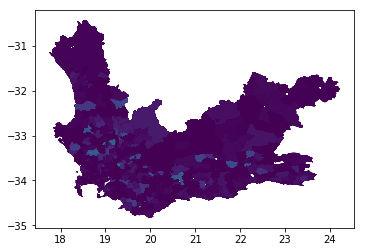

In [6]:
df.query('Crime == "Drug-related crime"').plot(column='total_crime')